In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.lstm(embedded, hidden)
        output = output.contiguous().view(-1, self.hidden_size)  # (batch_size*sequence_length, hidden_size)
        output = self.fc(output)  # (batch_size*sequence_length, num_classes)
        return output, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device),
                weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device))

In [3]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

class TextDataset(Dataset):
    def __init__(self, text, seq_length=200, batch_size=64):
        self.text = text
        self.seq_length = seq_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        sequence = self.text[idx:idx+self.seq_length]
        label = self.text[idx+1:idx+self.seq_length+1]
    
        return char_tensor(sequence), char_tensor(label)

# assuming that `text.txt` is your file and it's located at the current directory.
with open('mini_shakespeare.txt', 'r') as f:
    text = f.read()

all_characters = sorted(list(set(text)))
input_size = len(all_characters)
output_size = len(all_characters)

Epoch [1/10], Step [0/196], Loss: 4.0631
Epoch [1/10], Step [100/196], Loss: 2.4025
Epoch [2/10], Step [0/196], Loss: 1.8912
Epoch [2/10], Step [100/196], Loss: 1.5193
Epoch [3/10], Step [0/196], Loss: 1.2406
Epoch [3/10], Step [100/196], Loss: 0.9285
Epoch [4/10], Step [0/196], Loss: 0.7212
Epoch [4/10], Step [100/196], Loss: 0.5391
Epoch [5/10], Step [0/196], Loss: 0.4261
Epoch [5/10], Step [100/196], Loss: 0.3450
Epoch [6/10], Step [0/196], Loss: 0.2777
Epoch [6/10], Step [100/196], Loss: 0.2512
Epoch [7/10], Step [0/196], Loss: 0.2151
Epoch [7/10], Step [100/196], Loss: 0.1999
Epoch [8/10], Step [0/196], Loss: 0.1891
Epoch [8/10], Step [100/196], Loss: 0.1923
Epoch [9/10], Step [0/196], Loss: 0.1728
Epoch [9/10], Step [100/196], Loss: 0.1692
Epoch [10/10], Step [0/196], Loss: 0.1648
Epoch [10/10], Step [100/196], Loss: 0.1576


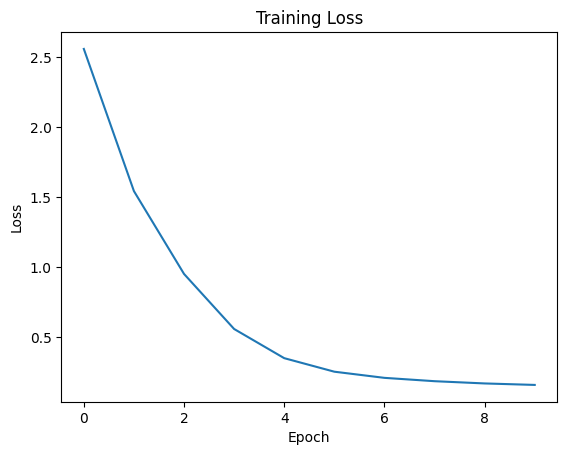

In [4]:
# Define hyperparameters
hidden_size = 128
n_layers = 2
learning_rate = 0.001
n_epochs = 10
print_every = 100
plot_every = 100

# Create the dataset and data loader
dataset = TextDataset(text)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CharRNN(input_size, hidden_size, output_size, n_layers).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Track the training loss over epochs
all_losses = []

# Set the start hidden state
hidden = model.init_hidden(64)

# Training loop
for epoch in range(1, n_epochs + 1):
    total_loss = 0.0
    #hidden = model.init_hidden(batch_size)
    for i, (input_batch, target_batch) in enumerate(itertools.islice(dataloader, len(dataloader)-1)):
            
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        optimizer.zero_grad()

        hidden = (hidden[0].detach(), hidden[1].detach())  # Detach the hidden state

        output, hidden = model(input_batch, hidden)

        loss = criterion(output.view(-1, output_size), target_batch.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % print_every == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' % (epoch, n_epochs, i, len(dataloader), loss.item()))

    all_losses.append(total_loss / len(dataloader))

    if epoch % plot_every == 0:
        plt.plot(all_losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

# Plot the final training loss
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [12]:
# Set the model to evaluation mode
model.eval()

# Set the sequence length
sequence_length = 1000

# Initialize the hidden state
hidden = model.init_hidden(1)

# Choose a starting character or seed
start_char = 'c'

# Convert the starting character to a tensor
input_tensor = char_tensor(start_char).unsqueeze(0)

# Create an empty list to store the generated sequence
generated_sequence = []

# Loop through each step of sequence generation
for _ in range(sequence_length):
    # Pass the input tensor and hidden state to the model
    output, hidden = model(input_tensor, hidden)

    # Sample the next character from the output distribution
    next_char_tensor = torch.multinomial(torch.exp(output.view(-1)), 1)
    next_char = all_characters[next_char_tensor.item()]

    # Append the sampled character to the generated sequence
    generated_sequence.append(next_char)

    # Set the input character for the next step as the sampled character
    input_tensor = char_tensor(next_char).unsqueeze(0)

# Join the generated sequence into a string
generated_sequence = ''.join(generated_sequence)

# Print the generated sequence
print(generated_sequence)

rttu, Senator:
Thein auts of s rakes the shagh done faultiteys you, what is grood.
With to be makes the sead to be complay told
The matter, you dissentious rogit one thoushes and well stone alread, poores
Leberice what we find common
Of the whole body. The belly answer'd--

First Citizen:
Well, sir, what answer made the first: for what miscarries
Shall se vile;
he hath firtms, but elpes a gunattion, the we their garners, thid ars grow uspetorceds.

MENENIUS:
Either you must
Confess yourselves wondrough the ridorfemb you the body?

First Citizen:
Liegiinst mourants;ould bus, and the body: but,
The Volsces are in arms.

MARCIUS:
They have a leaking
That were's a me at!

MARCIUS:
ere are friends for truest, which he is: who chat say you receive
The hearn awe, whoce heach in thim selvery, if they did complisting the worns at then?

First Citizen:
Should fid you have a leanes: if they whole bodyed belrearder

MENENIUS:
Ey, thit all them, all the sun tanest make bold proud.

First Citizen:
Y